In [ ]:
# import splitfolders

In [ ]:
# input_folders = 'F:/sleep monitoring project/Dataset reduce size/Thermal_size224/Thermal_Light_Off_Resized/Thermal_Light_Off_WithoutBlanket'
# out_folders = 'F:/sleep monitoring project/Dataset reduce size/Thermal_size224/Thermal_Light_Off_Resized/TM_Lf_Withblanket/Thermal_Light_Off_WithoutBlanket'
# splitfolders.ratio(input_folders, out_folders, seed=42, ratio=(.6, .2, .2))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras_preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from keras_preprocessing import image
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

In [ ]:
# Check if GPU is available and being used
import tensorflow as tf


len(tf.config.list_physical_devices('GPU'))>0

True

In [ ]:
train_data = '/content/drive/MyDrive/Thermal_Light_Off_WithoutBlanket/train'
val_data = '/content/drive/MyDrive/Thermal_Light_Off_WithoutBlanket/val'
test_data = '/content/drive/MyDrive/Thermal_Light_Off_WithoutBlanket/test'

In [ ]:
img_height, img_width = (224, 224)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=1.0 / 255.0,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.4
)

In [ ]:
train_datagenerator = train_datagen.flow_from_directory(
    train_data,
    target_size= (img_height, img_width),
    batch_size= batch_size,
    class_mode= "categorical",
    subset= 'training'
)

val_datagenerator = train_datagen.flow_from_directory(
    val_data,
    target_size= (img_height, img_width),
    batch_size= batch_size,
    class_mode= "categorical",
    subset= 'validation'
)


Found 3944 images belonging to 5 classes.
Found 2376 images belonging to 5 classes.


In [ ]:
test_datagenerator = train_datagen.flow_from_directory(
    test_data,
    target_size= (img_height, img_width),
    batch_size= 1,
    class_mode= "categorical",
    subset= 'validation'
)

Found 2949 images belonging to 5 classes.


In [ ]:
x, y = test_datagenerator.next()
x.shape

(1, 224, 224, 3)

Pre-trained ResNet50 model

In [ ]:
# Load the pre-trained ResNet50 model without the top classification layers.
from keras.optimizers import Adam
base_model = ResNet50(include_top=False, weights='imagenet')

# Add custom classification layers on top of the base model.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_datagenerator.num_classes, activation='softmax')(x)

# Create the model.
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer and categorical cross-entropy loss.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
histrory = model.fit(train_datagenerator, validation_data= val_datagenerator, epochs=150)

Epoch 1/150


KeyboardInterrupt: ignored

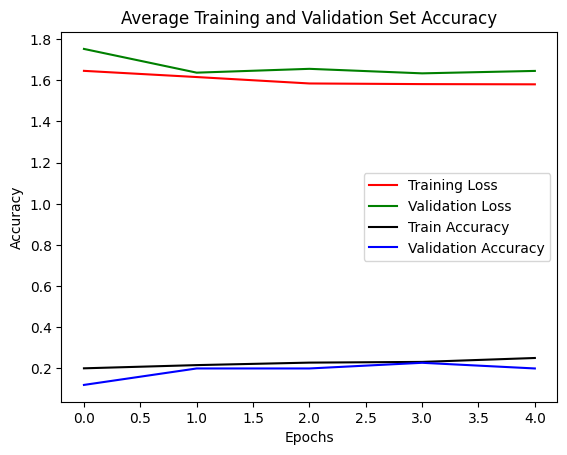

In [ ]:
# Plotting Training
plt.plot(histrory.history['loss'], '-', color='red', label='Training Loss')
plt.plot(histrory.history['val_loss'], '-', color='green', label='Validation Loss')
plt.plot(histrory.history['accuracy'], '-', color='black', label='Train Accuracy')
plt.plot(histrory.history['val_accuracy'], '-', color='Blue', label='Validation Accuracy')
plt.title('Average Training and Validation Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_datagenerator, verbose=2)
val_loss, val_acc = model.evaluate(val_datagenerator, verbose=2)
test_loss, test_acc = model.evaluate(test_datagenerator, verbose=2)


print(f"Training Accuracy: {train_acc} and Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc} and Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc} and Test Loss: {test_loss}")

19/19 - 9s - loss: 1.5695 - accuracy: 0.2336 - 9s/epoch - 494ms/step
13/13 - 8s - loss: 1.6462 - accuracy: 0.2000 - 8s/epoch - 653ms/step
587/587 - 318s - loss: 1.6499 - accuracy: 0.2044 - 318s/epoch - 542ms/step
Training Accuracy: 0.23356401920318604 and Training Loss: 1.5694893598556519
Validation Accuracy: 0.20000000298023224 and Validation Loss: 1.6461695432662964
Test Accuracy: 0.20442929863929749 and Test Loss: 1.6499066352844238


In [ ]:
filename= test_datagenerator.filenames
nb_sample = len(test_datagenerator)
y_prob = []
y_act = []
test_datagenerator.reset()

for _ in range(nb_sample):
    X_test, Y_test = test_datagenerator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predict_class = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_classes = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_act]

1/1 [==============================] - 0s 26ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classes = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']
print("Test Result:================================================")
print(f"Accuracy Score: {accuracy_score(actual_classes, predict_class) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(actual_classes, predict_class, target_names=classes)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(actual_classes, predict_class)}")

Test Result:================================================
Accuracy Score: 20.44%
_______________________________________________
CLASSIFICATION REPORT:
                precision    recall  f1-score   support

      Left Log       0.00      0.00      0.00       120
    Prone Left       0.20      1.00      0.34       120
   Prone Right       0.00      0.00      0.00       120
     Right Log       0.00      0.00      0.00       120
Supine_Thermal       0.00      0.00      0.00       107

      accuracy                           0.20       587
     macro avg       0.04      0.20      0.07       587
  weighted avg       0.04      0.20      0.07       587

_______________________________________________
Confusion Matrix: 
[[  0 120   0   0   0]
 [  0 120   0   0   0]
 [  0 120   0   0   0]
 [  0 120   0   0   0]
 [  0 107   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


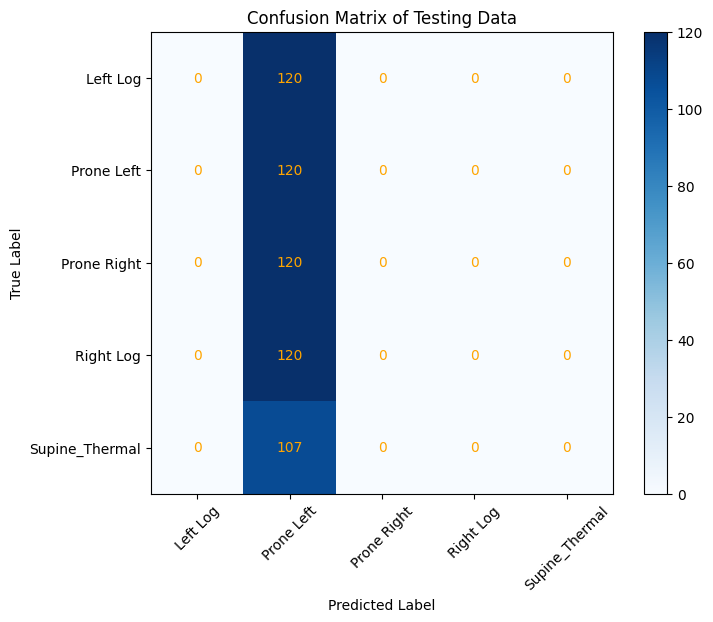

In [ ]:
class_labels = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']  # Modify the labels based on your actual class names
cm = confusion_matrix(actual_classes, predict_class)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Testing Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell cmap='Blues', annot=True, fmt='d'
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='orange')

plt.show()

Pre-Train VGG16 model

In [ ]:
# By default, the VGG16 model expects images as input with the size 224 x 224 pixels with 3 channels
image_size = 224
input_shape = (image_size, image_size, 3)
# Define CNN model constants
epochs = 10
batch_size = 32

In [ ]:
# Define our pre-trained model
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import layers

pre_trained_model = VGG16(include_top=False, weights="imagenet")

# Flatten the output layer to one dimension
x = GlobalAveragePooling2D()(pre_trained_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
predictions = layers.Dense(train_datagenerator.num_classes, activation='softmax')(x)
# Form our model
VGG16_model = Model(inputs=pre_trained_model.input, outputs= predictions)
for layer in pre_trained_model.layers:
    layer.trainable = False
# Compile the model with Adam optimizer and categorical cross-entropy loss.
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = VGG16_model.fit(train_datagenerator, validation_data= val_datagenerator, epochs=10)

Epoch 1/10
235/235 [==============================] - 236s 964ms/step - loss: 1.3680 - accuracy: 0.5633 - val_loss: 1.3594 - val_accuracy: 0.4874
Epoch 2/10
235/235 [==============================] - 72s 304ms/step - loss: 0.9650 - accuracy: 0.8413 - val_loss: 1.1333 - val_accuracy: 0.7158
Epoch 3/10
235/235 [==============================] - 73s 312ms/step - loss: 0.6570 - accuracy: 0.9266 - val_loss: 1.0028 - val_accuracy: 0.6817
Epoch 4/10
235/235 [==============================] - 71s 303ms/step - loss: 0.4626 - accuracy: 0.9538 - val_loss: 0.8869 - val_accuracy: 0.7572
Epoch 5/10
235/235 [==============================] - 74s 316ms/step - loss: 0.3320 - accuracy: 0.9697 - val_loss: 0.8176 - val_accuracy: 0.7746
Epoch 6/10
235/235 [==============================] - 72s 306ms/step - loss: 0.2465 - accuracy: 0.9798 - val_loss: 0.7599 - val_accuracy: 0.7992
Epoch 7/10
235/235 [==============================] - 72s 304ms/step - loss: 0.1853 - accuracy: 0.9876 - val_loss: 0.7277 - val_a

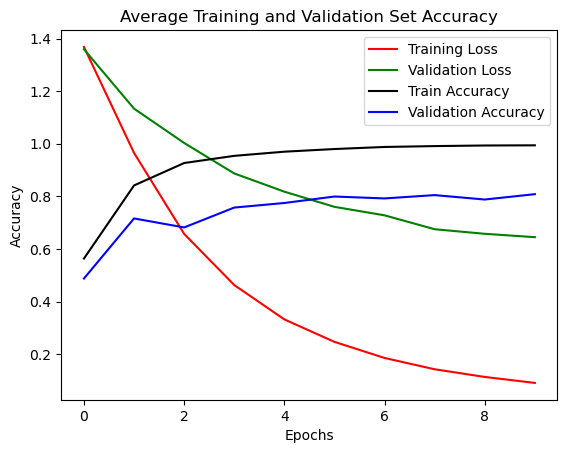

In [ ]:
# Plotting Training
plt.plot(history.history['loss'], '-', color='red', label='Training Loss')
plt.plot(history.history['val_loss'], '-', color='green', label='Validation Loss')
plt.plot(history.history['accuracy'], '-', color='black', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], '-', color='Blue', label='Validation Accuracy')
plt.title('Average Training and Validation Set Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = VGG16_model.evaluate(train_datagenerator, verbose=2)
val_loss, val_acc = VGG16_model.evaluate(val_datagenerator, verbose=2)
test_loss, test_acc = VGG16_model.evaluate(test_datagenerator, verbose=2)


print(f"Training Accuracy: {train_acc} and Training Loss: {train_loss}")
print(f"Validation Accuracy: {val_acc} and Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_acc} and Test Loss: {test_loss}")

235/235 - 58s - loss: 0.0821 - accuracy: 0.9931 - 58s/epoch - 247ms/step
53/53 - 13s - loss: 0.6606 - accuracy: 0.7842 - 13s/epoch - 243ms/step
1670/1670 - 31s - loss: 0.6572 - accuracy: 0.7982 - 31s/epoch - 19ms/step
Training Accuracy: 0.9930823445320129 and Training Loss: 0.08207797259092331
Validation Accuracy: 0.7841726541519165 and Validation Loss: 0.6605651378631592
Test Accuracy: 0.7982035875320435 and Test Loss: 0.6572385430335999


In [ ]:
filename= test_datagenerator.filenames
nb_sample = len(test_datagenerator)
y_prob = []
y_act = []
test_datagenerator.reset()

for _ in range(nb_sample):
    X_test, Y_test = test_datagenerator.next()
    y_prob.append(VGG16_model.predict(X_test))
    y_act.append(Y_test)

VGG16_predict_class = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_prob]
VGG16_actual_classes = [list(train_datagenerator.class_indices.keys())[i.argmax()] for i in y_act]

1/1 [==============================] - 0s 18ms/step


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classes = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']
print("Test Result:================================================")
print(f"Accuracy Score: {accuracy_score(VGG16_actual_classes, VGG16_predict_class) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(VGG16_actual_classes, VGG16_predict_class, target_names=classes)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(VGG16_actual_classes, VGG16_predict_class)}")

Test Result:================================================
Accuracy Score: 79.76%
_______________________________________________
CLASSIFICATION REPORT:
                precision    recall  f1-score   support

      Left Log       0.90      0.95      0.93       266
    Prone Left       0.69      0.87      0.77       361
   Prone Right       0.68      0.93      0.79       356
     Right Log       0.95      0.70      0.80       395
Supine_Thermal       1.00      0.54      0.71       292

      accuracy                           0.80      1670
     macro avg       0.84      0.80      0.80      1670
  weighted avg       0.84      0.80      0.79      1670

_______________________________________________
Confusion Matrix: 
[[254   0   8   4   0]
 [ 21 313  18   9   0]
 [  2  23 331   0   0]
 [  2  69  49 275   0]
 [  2  51  78   2 159]]


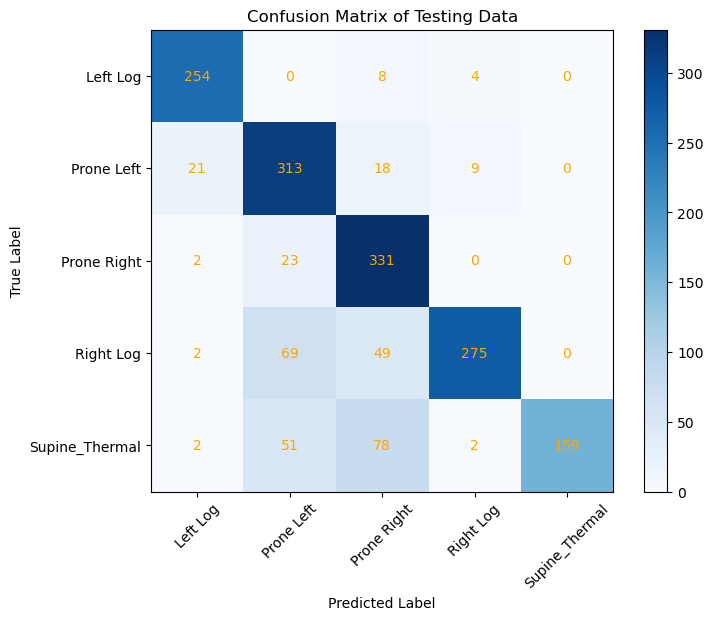

In [ ]:
class_labels = ['Left Log', 'Prone Left', 'Prone Right', 'Right Log', 'Supine_Thermal']  # Modify the labels based on your actual class names
VGG16_cm = confusion_matrix(VGG16_actual_classes, VGG16_predict_class)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(VGG16_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Testing Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell cmap='Blues', annot=True, fmt='d'
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(VGG16_cm[i, j]), ha='center', va='center', color='orange')

plt.show()

In [47]:
import os
import cv2
from PIL import Image

# Mapping of video keywords to label names
label_mapping = {
    "Ahsan Posture": "Ahsan Posture",
    "Awais Posture": "Awais Posture",
    "Senghour Posture": "Senghour Posture",
    "Vesal Posture": "Vesal Posture"
}
Posture = {
    "Supine",
    "Left Log",
    "Right Log",
    "Prone Left",
    "Prone Right"

}
def convert_video_to_frames(video_path, output_folder):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    # Extract the label name from the video's filename
    label = get_label_name(video_path)

    while True:  # Changed from while video_capture.isOpened()
        ret, frame = video_capture.read()
        if not ret:
            break

        frame_count += 1
        frame_name = f"{label}_{frame_count:04d}.jpg"  # Padded with zeros for sorting
        frame_path = os.path.join(output_folder, frame_name)

        # Resize the frame to the desired dimensions
        resized_frame = cv2.resize(frame, (224, 224))

        # Convert the frame to PIL Image format
        pil_image = Image.fromarray(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

        # Save the resized frame
        pil_image.save(frame_path)

    video_capture.release()
    print(f"Converted video: {video_path} to frames.")

def get_label_name(video_path):
    # Get the video's filename without extension
    video_filename = os.path.basename(video_path)
    video_filename_without_extension = os.path.splitext(video_filename)[0]

    # Extract the label keyword from the video's filename
    for keyword, label in label_mapping.items():
        if keyword in video_filename_without_extension:
            return label

    # Return a default label if no keyword is found
    return "Unknown"

def convert_folder_to_frames(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(".mov"):  # Lowercase the extension for comparison
                video_path = os.path.join(root, file)
                relative_path = os.path.relpath(video_path, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                os.makedirs(output_subfolder, exist_ok=True)
                convert_video_to_frames(video_path, output_subfolder)

# Define the input and output folder paths
input_root = "F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/"
output_root = "F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on_WithBlanket"
# Convert RGB videos to frames
rgb_input_folder = os.path.join(input_root)
rgb_output_folder = os.path.join(output_root)
convert_folder_to_frames(rgb_input_folder, rgb_output_folder)


Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Left Log\Ahsan Left Log.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Left Log\Awias Left Log.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Left Log\Senghour Left Log.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Left Log\Vesal Left Log.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Prone Left\Ahsan Prone Left.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Prone Left\Awias Prone Left.MOV to frames.
Converted video: F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_on/Prone Left\Senghour Prone Left.MOV to frames.
Converted video: F:/sleep monitoring project

In [45]:
rgb_input_folder

'F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_off/'

In [46]:
rgb_output_folder

'F:/sleep monitoring project/Dataset reduce size/RGB/RGB New test/RGB_Light_off_WithBlanket'

In [40]:
video_path

'F:/sleep monitoring project\\Dataset reduce size\\RGB\\RGB New test\\RGB_Light_on\\Supine\\Ahsan Supine.MOV'

In [37]:
import cv2
import os
from PIL import Image

def convert_video_to_frames(video_path, output_path, label):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not video.isOpened():
        print("Error opening video file")
        return

    # Get the video's frames per second (fps) and frame dimensions
    fps = int(video.get(cv2.CAP_PROP_FPS))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Initialize frame count
    frame_count = 0

    # Iterate through the video frames
    while True:
        # Read the frame from the video
        success, frame = video.read()

        # Break the loop if the video has ended
        if not success:
            break

        # Resize the frame to the desired dimensions (224, 224)
        resized_frame = cv2.resize(frame, (224, 224))

        # Save the resized frame as an image file
        frame_filename = f"{label}_{frame_count:04d}.jpg"
        frame_path = os.path.join(output_path, frame_filename)

        # Convert the frame to PIL Image format
        pil_image = Image.fromarray(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))

        # Save the resized frame
        pil_image.save(frame_path)

        frame_count += 1

    # Release the video object
    video.release()
    print(f"Frames extracted: {label}_{frame_count}")

# Example usage
label = "A Supine"
video_filename = f"{label}.MOV"
video_path = os.path.join(
    "F:/sleep monitoring project",
    "Dataset reduce size",
    "RGB",
    "RGB New test",
    "RGB_Light_on",
    "Supine",
    video_filename,
)
output_path = os.path.join("F:/sleep monitoring project",
                           "Dataset reduce size",
                           "RGB",
                           "RGB New test",
                           "RGB_Light_on_WithBlanket",
                           "Supine")

convert_video_to_frames(video_path, output_path, label)


Frames extracted: Ahsan Supine_5464


In [35]:
video_path

'F:/sleep monitoring project\\Dataset reduce size\\RGB\\RGB New test\\RGB_Light_on\\Supine\\Ahsan Supine.mp4'

In [36]:
output_path

'F:/sleep monitoring project\\Dataset reduce size\\RGB\\RGB New test\\RGB_Light_on_WithBlanket\\Supine'

In [58]:
import os
import shutil

# Replace this path with your actual folder path
source_folder_path = r"F:\sleep monitoring project\Dataset reduce size\RGB\RGB New test\RGB_Light_on_WithBlanket\Supine"

# Replace this path with the destination folder path
destination_folder_path = r"F:\sleep monitoring project\Dataset reduce size\RGB\RGB New test\RGB_Light_on_WithBlanket\Supine"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder_path, exist_ok=True)

# Move all files from subfolders to the destination folder
for root, _, files in os.walk(source_folder_path):
    for file in files:
        source_path = os.path.join(root, file)
        shutil.move(source_path, destination_folder_path)

print("All folders merged into a single folder successfully.")


All folders merged into a single folder successfully.
